In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from algorithms import *
from benchmark import *

# Definition of variables
benchmarkfunction_list = [StybliskiTang, Rastrigin, Rosenbrock, Beale, Sphere, Perm, GoldsteinPrice, Ackley, Bohachevsky] #Hartmann
algorithms_list        = [bayesian_optimization, bfgs, latin_hypercube, nelder_mead, particle_swarm, response_surface, sobol]


# Find the global minimum throughout the sampling process for model-based algorithms
def best_history(data): 
    best = []
    for i,cd in enumerate(data):
        if (i == 0): best.append(cd)
        else:
            if (cd < best[-1]): best.append(cd)
            else: best.append(best[-1])
    return best

## Bayesian Optimization: study on the initialization effect

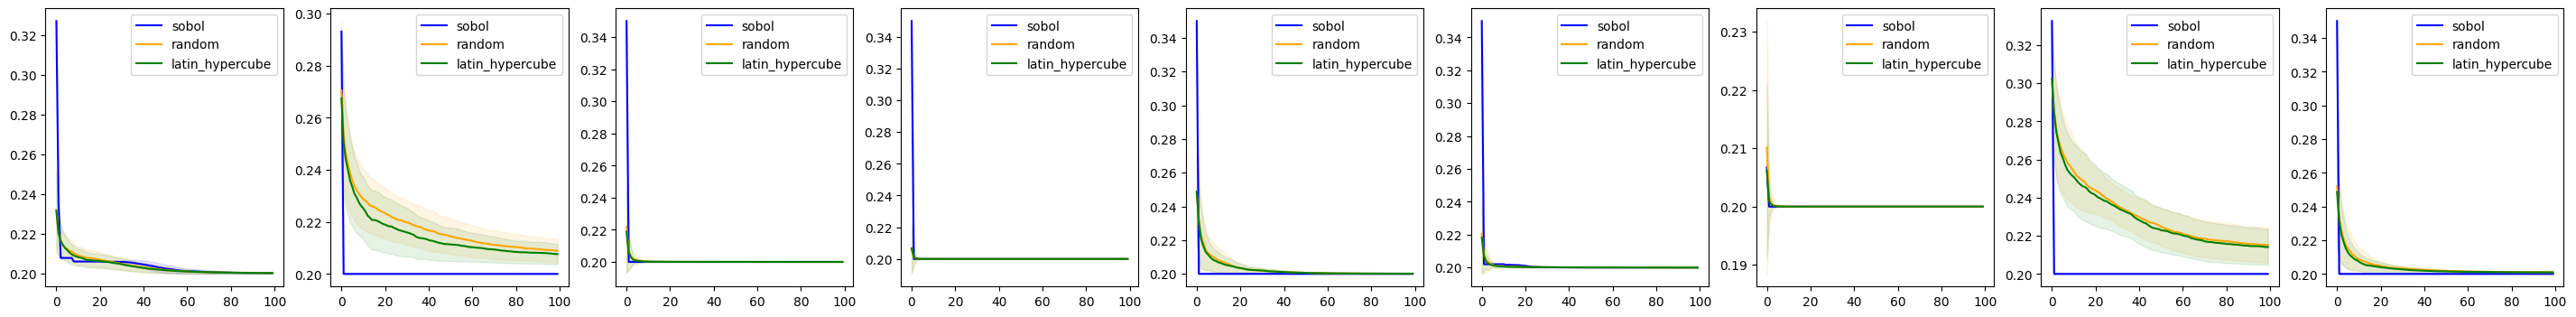

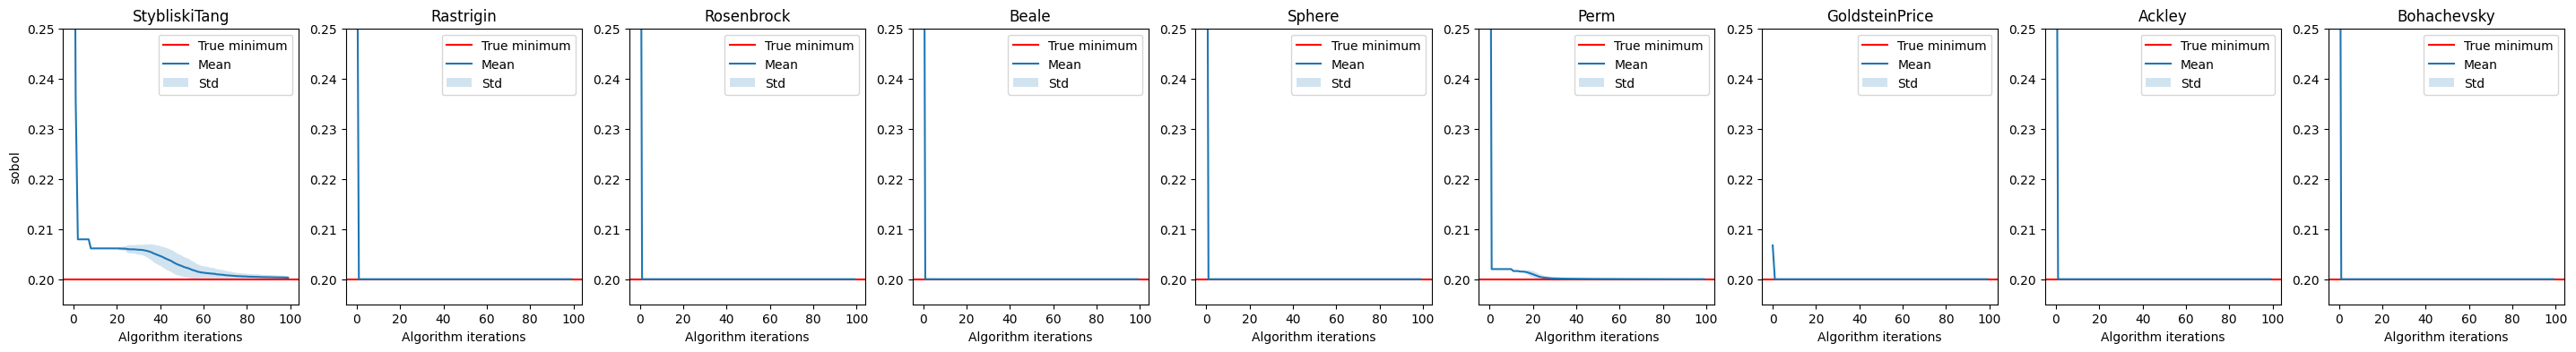

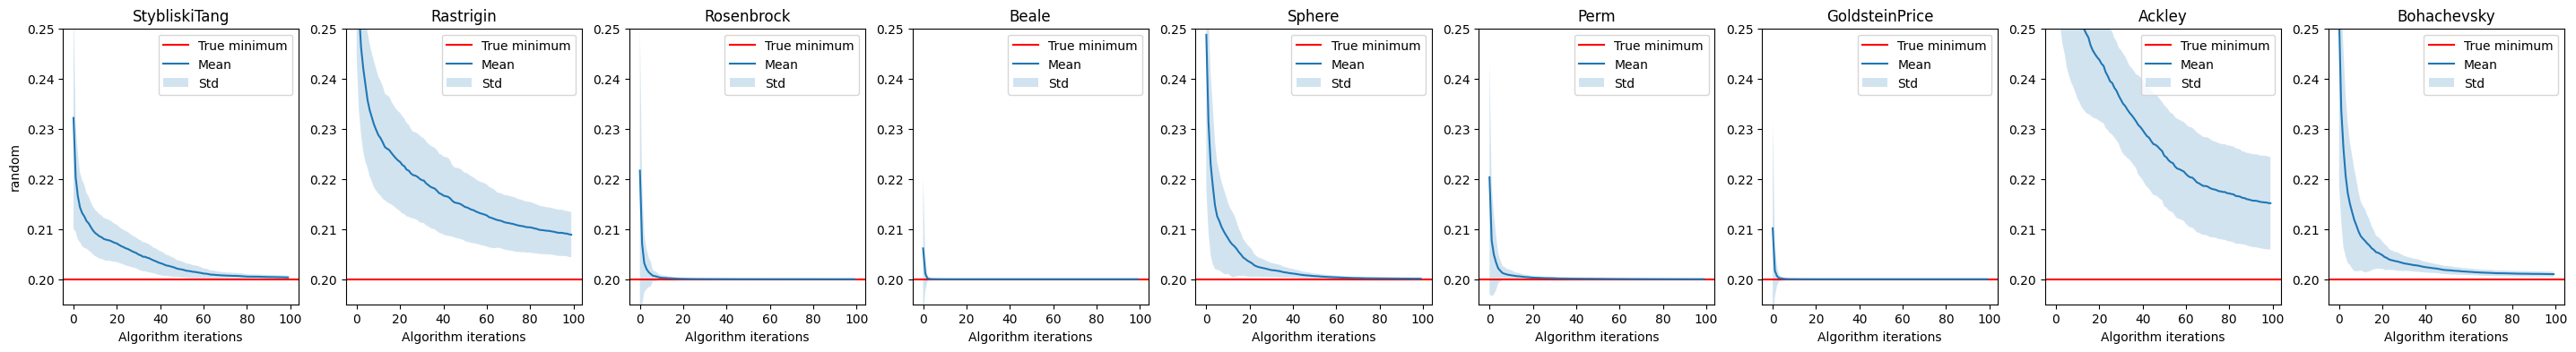

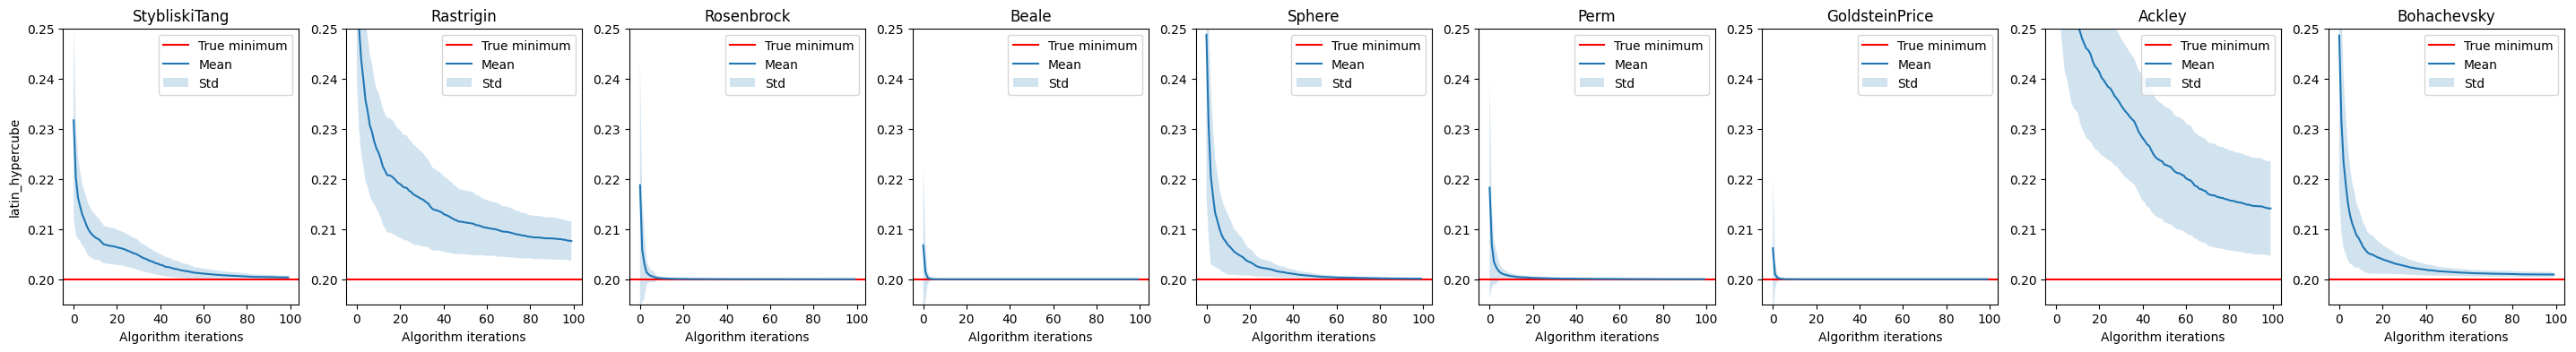

In [2]:
# Set the number of points to consider for each test
sampling_budget = 100

# Set the number of tests to run, on which estimate the standard deviation and mean
tests  = 250

X1 =  X2 = np.linspace(-5, 5, 101)
points = np.array([[x1,x2] for x1 in X1 for x2 in X2])

fig_shared, ax_shared = plt.subplots(1, len(benchmarkfunction_list), figsize=(4*len(benchmarkfunction_list), 4))
colors = ["blue","orange","green"]

# Set the initialization methods than must be tested
init_methods = ["sobol","random","latin_hypercube"]

for ii, method in enumerate(init_methods):

    # Set the new plots
    fig, ax = plt.subplots(1, len(benchmarkfunction_list), figsize=(4*len(benchmarkfunction_list), 4))

    for idx, fcn in enumerate(benchmarkfunction_list):

        # Estimate the function output
        Fx = fcn(points.T)

        # Rescaling the function to 0.20 - 0.35 range
        Fn = lambda p: (fcn(p) - np.min(Fx)) * (0.15)/(np.max(Fx) - np.min(Fx)) + 0.20

        Y_log = []
        for test in range(tests): 
            Xmin, Ymin, X, Y = bayesian_optimization(Fn, sampling_budget=sampling_budget, sampling_method = method)
            Y_log.append(best_history(Y))

        # Calculate mean and standard deviation for the tests at the sampling_budget=budget
        Ystd  = np.std(Y_log, axis=0)
        Ymean = np.mean(Y_log, axis=0)

        # Plot the performances
        ax[idx].axhline(y = np.min(Fn(points.T)), color = 'r', linestyle = '-')

        ax[idx].plot(range(len(Ymean)), Ymean)
        ax[idx].fill_between(range(len(Ymean)), Ymean - Ystd, Ymean + Ystd, alpha=0.2, label='Standard Deviation')
        ax[idx].set_ylim([0.195, 0.25])
        ax[idx].set_title(fcn.__name__)
        ax[idx].set_xlabel("Algorithm iterations")
        ax[idx].legend(["True minimum", "Mean", "Std"])
        if (idx == 0): ax[idx].set_ylabel(method)

        ax_shared[idx].plot(range(len(Ymean)), Ymean, label=method, c=colors[ii])
        ax_shared[idx].fill_between(range(len(Ymean)), Ymean - Ystd, Ymean + Ystd, alpha=0.1, color=colors[ii])
        ax_shared[idx].legend()

plt.show()

## Particle Swarm Optimization: study on the initialization effect

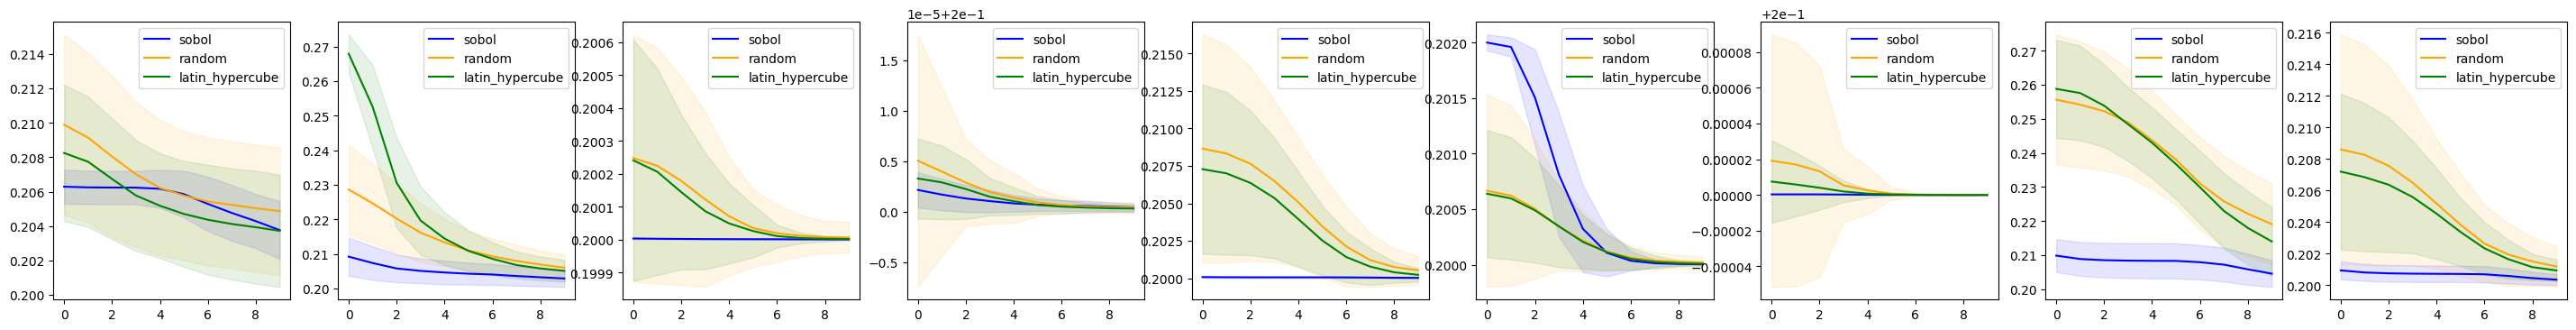

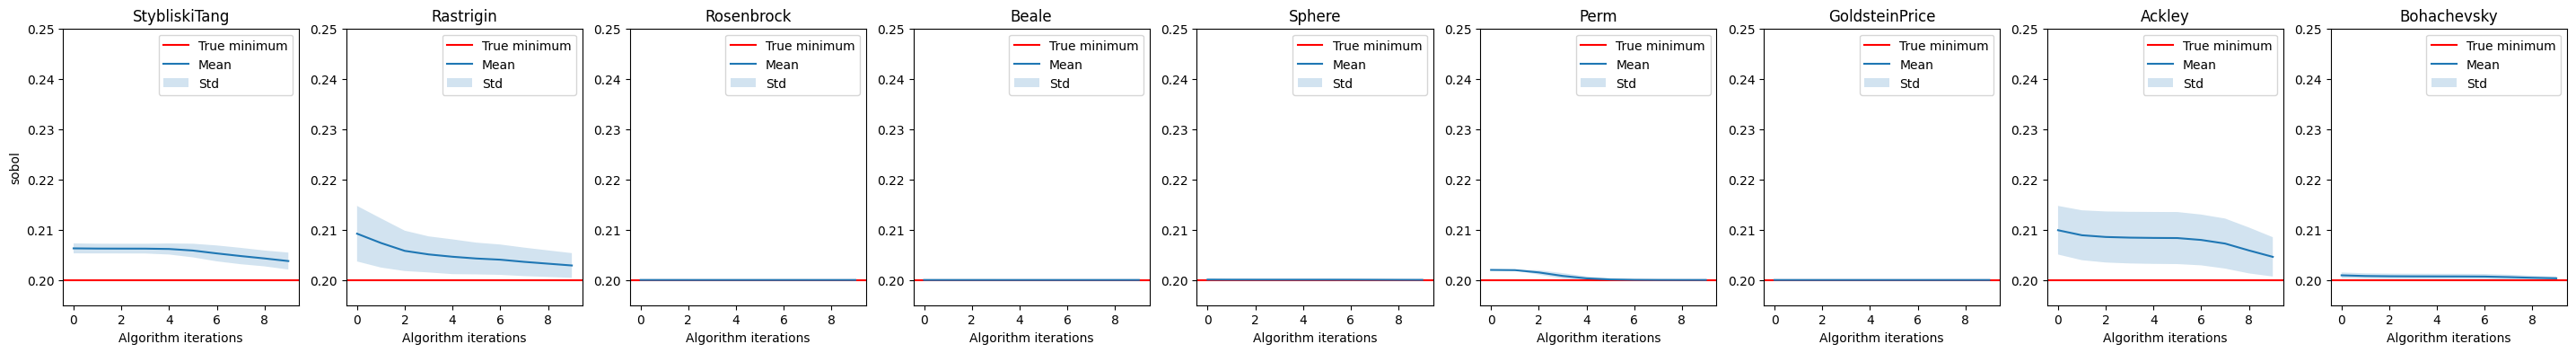

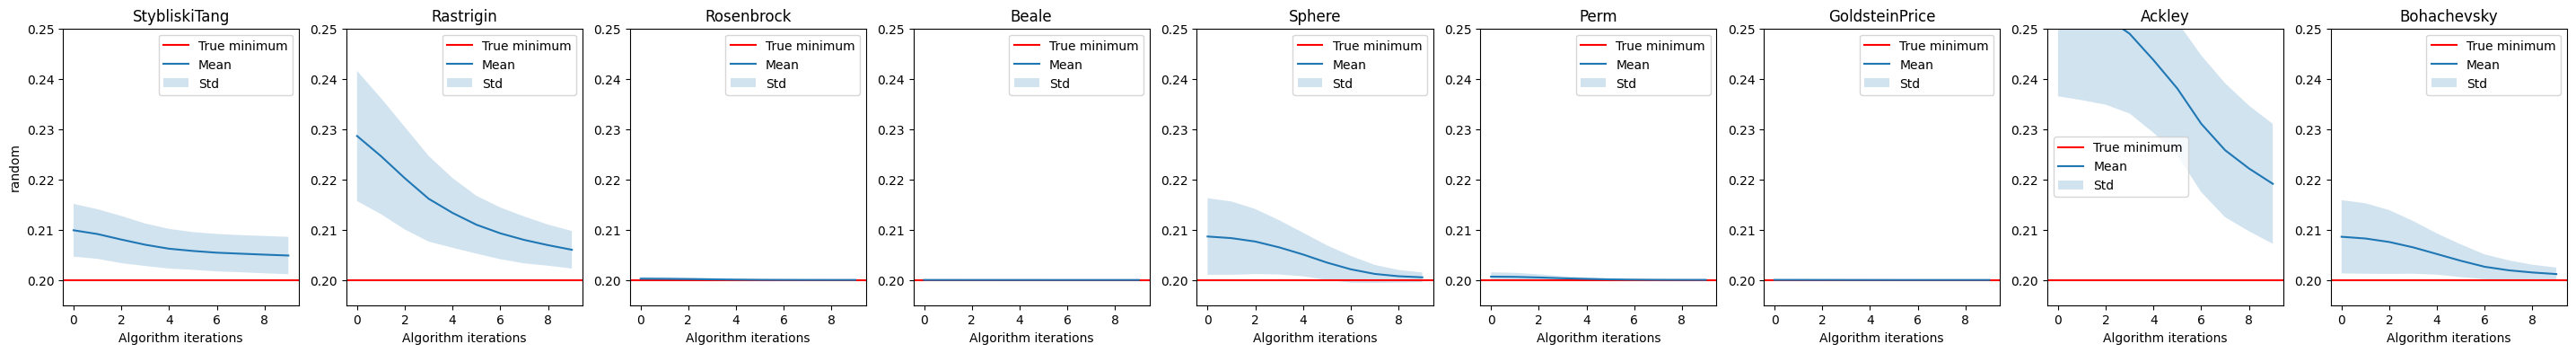

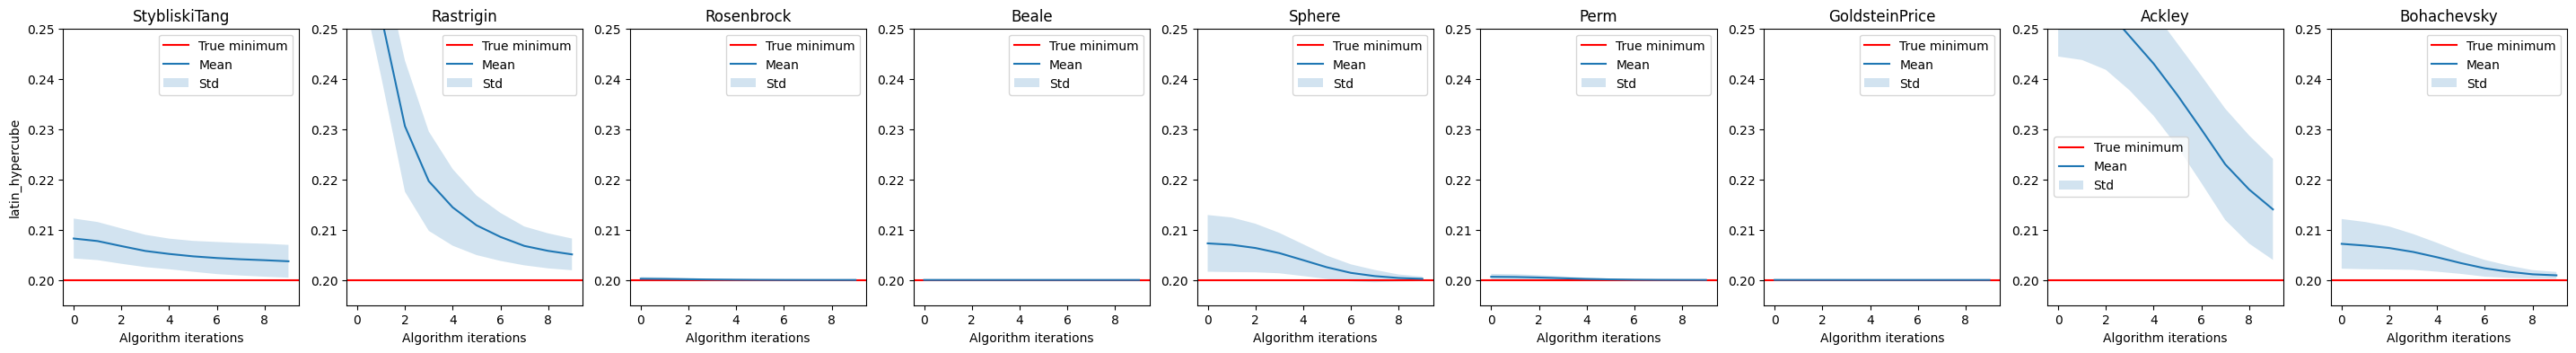

In [4]:
# Set the number of points to consider for each test
sampling_budget = 100

# Set the number of tests to run, on which estimate the standard deviation and mean
tests  = 250

X1 =  X2 = np.linspace(-5, 5, 101)
points = np.array([[x1,x2] for x1 in X1 for x2 in X2])

fig_shared, ax_shared = plt.subplots(1, len(benchmarkfunction_list), figsize=(4*len(benchmarkfunction_list), 4))
colors = ["blue","orange","green"]

# Set the initialization methods than must be tested
init_methods = ["sobol","random","latin_hypercube"]

for ii, method in enumerate(init_methods):

    # Set the new plots
    fig, ax = plt.subplots(1, len(benchmarkfunction_list), figsize=(4*len(benchmarkfunction_list), 4))

    for idx, fcn in enumerate(benchmarkfunction_list):

        # Estimate the function output
        Fx = fcn(points.T)

        # Rescaling the function to 0.20 - 0.35 range
        Fn = lambda p: (fcn(p) - np.min(Fx)) * (0.15)/(np.max(Fx) - np.min(Fx)) + 0.20

        Y_log = []
        for test in range(tests): 
            Xmin, Ymin, X, Y = particle_swarm(Fn, sampling_budget=sampling_budget, sampling_method = method)
            Y_log.append(best_history(Y))

        # Calculate mean and standard deviation for the tests at the sampling_budget=budget
        Ystd  = np.std(Y_log, axis=0)
        Ymean = np.mean(Y_log, axis=0)

        # Plot the performances
        ax[idx].axhline(y = np.min(Fn(points.T)), color = 'r', linestyle = '-')

        ax[idx].plot(range(len(Ymean)), Ymean)
        ax[idx].fill_between(range(len(Ymean)), Ymean - Ystd, Ymean + Ystd, alpha=0.2, label='Standard Deviation')
        ax[idx].set_ylim([0.195, 0.25])
        ax[idx].set_title(fcn.__name__)
        ax[idx].set_xlabel("Algorithm iterations")
        ax[idx].legend(["True minimum", "Mean", "Std"])
        if (idx == 0): ax[idx].set_ylabel(method)

        ax_shared[idx].plot(range(len(Ymean)), Ymean, label=method, c=colors[ii])
        ax_shared[idx].fill_between(range(len(Ymean)), Ymean - Ystd, Ymean + Ystd, alpha=0.1, color=colors[ii])
        ax_shared[idx].legend()

plt.show()